In [1]:
import random
from copy import deepcopy
from math import log10

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.axes import Axes

In [2]:
def stake_transformation(values, slope, curvature, threshold):
    transformed_stakes = []

    for x in values:
        if x <= 30e3:
            transformed_stakes.append(0.0001)
        elif x <= threshold:
            f_x = slope * x
            transformed_stakes.append(f_x)
        else:
            g_x = slope * threshold  + (x - threshold) ** (1 / curvature)
            transformed_stakes.append(g_x)

    return transformed_stakes

def compute_probabilities(stakes: list):
    sum_stakes = sum(stakes)
    return [s / sum_stakes for s in stakes]

def compute_rewards(probabilities: list, budget: int):
    return [p * budget for p in probabilities]

def compute_apy(opt: dict, data: list, percentage: bool = False):
    transformed_stakes = stake_transformation(data, **opt["model_arguments"])

    probabilities = compute_probabilities(transformed_stakes)

    rewards = compute_rewards(probabilities, opt["budget"])

    period_apy = [r / s for r, s in zip(rewards, transformed_stakes)]
    yearly_apy = [apy * 12 / opt["period_in_months"] for apy in period_apy]
    
    apy = sum(yearly_apy) / len(yearly_apy)

    if percentage:
        return apy * 100
    
    return apy

def factor_and_prefix(value):
    factor = int(int(log10(value))/3)*3
    if factor < 3:
        prefix = ""
    elif factor < 6:
        prefix = "k"
    elif factor < 9:
        prefix = "M"

    return 10**factor, prefix

def probabilistic_apy(datas: list[list], options: list[dict], steps:int = 100):
    result_template = {"apys": [], "average": 0}

    results = [deepcopy(result_template) for _ in range(len(options))]

    for idx, opt in enumerate(options):
        for _ in range(steps):
            stakes = sum([random.sample(data, count) for data, count in zip(datas, opt["data_count"])], [])

            tf_stakes = stake_transformation(stakes, **opt["model_arguments"])
            
            apy = compute_apy(opt, tf_stakes, percentage=False)

            results[idx]["apys"].append(apy)

        results[idx]["average"] = np.mean(results[idx]["apys"])
        results[idx]["std"] = np.std(results[idx]["apys"])

    return results

def generate_simulation_graph(datas:list[list], options: list[dict], steps: int = 200, title: str = None):
    cols = 3
    rows = int(len(options) / cols + 0.5)
    if rows * cols < len(options):
        rows += 1
        
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols*6,rows*6), dpi=300)

    axes = [axes] if isinstance(axes, Axes) else axes.flatten()

    results = probabilistic_apy(datas, options, steps)


    for opt, result, ax in zip(options, results, axes):
        max_stakes = max([max(data) for data, count in zip(datas, opt["data_count"]) if count])
        stakes = np.linspace(0, max_stakes, 1000)
        factor, prefix = factor_and_prefix(stakes[-1])
        
        tf_stakes = stake_transformation(stakes, **opt["model_arguments"])

        data_points = sum([random.sample(data, count) for data, count in zip(datas, opt["data_count"])], [])
        tf_data_points = stake_transformation(data_points, **opt["model_arguments"])

        stakes_for_plt = [s/factor for s in stakes]
        tf_stakes_for_plt = [s/factor for s in tf_stakes]

        data_points_for_plt = [s/factor for s in data_points]
        tf_data_points_for_plt = [s/factor for s in tf_data_points]
        
        messages_per_second = opt["budget"] / (opt["ticket_options"]["price"] * opt["ticket_options"]["winning_probability"]) / (opt["period_in_months"] * 30 * 24 * 60 * 60)


        ax.plot(stakes_for_plt, tf_stakes_for_plt, label=opt["legend"])
        ax.scatter(data_points_for_plt, tf_data_points_for_plt, s=12, alpha=0.8, c="#ff7f0e")

        ax.set_xlabel(f"Staking (/{prefix}/HOPR)")
        ax.set_ylabel(f"Transformed Staking (/{prefix}/HOPR)")
        ax.text(0.1,
                0.8,
                f"APY: {result['average']:.2%} (+- {result['std']:.2%})",
                transform=ax.transAxes, 
                horizontalalignment='left', 
                bbox=dict(facecolor='red', alpha=0.5),)
        ax.text(0.1,
                0.7,
                f"Messages/s: {messages_per_second:.2f}",
                transform=ax.transAxes, 
                horizontalalignment='left', 
                bbox=dict(facecolor='blue', alpha=0.5),)
        
        # set the x and y scale equal
        ax.set_aspect('equal', adjustable='box')
        ax.set_ylim(ax.get_xlim())
        
        ax.legend()
        ax.grid()

    # remove unused axes
    for ax in axes[len(options):]:
        ax.remove()
        
    if title:
        if len(options) == 1:
            plt.title(title, fontsize=10)
        else:
            fig.suptitle(title, fontsize=20)
    plt.subplots_adjust(top=0.9)
    plt.show()

def generate_simulation_graph_simple(options: list[dict], steps: int, title: str = None):
    rows = 1
    cols = int(len(options) / rows + 0.5)
    if rows * cols < len(options):
        cols += 1
        
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols*6,rows*6), dpi=300)

    axes = [axes] if isinstance(axes, Axes) else axes.flatten()

    for opt, ax in zip(options, axes):        
        stakes = np.linspace(0, 1e6, steps)
        
        tf_stakes = stake_transformation(stakes, **opt["model_arguments"])
        
        ax.plot(stakes, tf_stakes)
        ax.set_xlabel(f"Stakes (HOPR)")
        ax.set_ylabel(f"Transformed Stakes (HOPR)")
    
        # set the x and y scale equal
        ax.set_aspect('equal', adjustable='box')
        ax.set_ylim(ax.get_xlim())
        
        ax.grid()

    # remove unused axes
    for ax in axes[len(options):]:
        ax.remove()
        
    if title:
        fig.suptitle(title, fontsize=20)
    plt.subplots_adjust(top=0.9)
    plt.show()

In [3]:
raw_all = pd.read_csv("all_01H7Z22K1VRTXCWJJJFV2A64VP.csv", low_memory=False)
raw_nft = pd.read_csv("nft_01H7Z2W99SMWJ01YN552WSRADV.csv", low_memory=False)

raw_data = pd.merge(raw_all, raw_nft, on="account", how="left")

condition = raw_data["token_id"].isnull()

staking_info_nft_holders = list(raw_data[~condition]["actual_stake_x"])
staking_info_non_nft_holders = list(raw_data[condition]["actual_stake_x"])
staking_info_all = list(raw_data["actual_stake_x"])

datas = [staking_info_nft_holders, staking_info_non_nft_holders, [500_000]]

prefered = {
    "data_count": [len(staking_info_nft_holders), 0, 0],
    "budget": 300_000,
    "period_in_months": 3,
    "model_arguments": {
        "slope": 1,
        "curvature":1.125,
        "threshold":100e3,
    },
    "ticket_options": {
        "price": 0.001,
        "winning_probability": 1,
    },
    "legend": "",
}

### Economic model

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


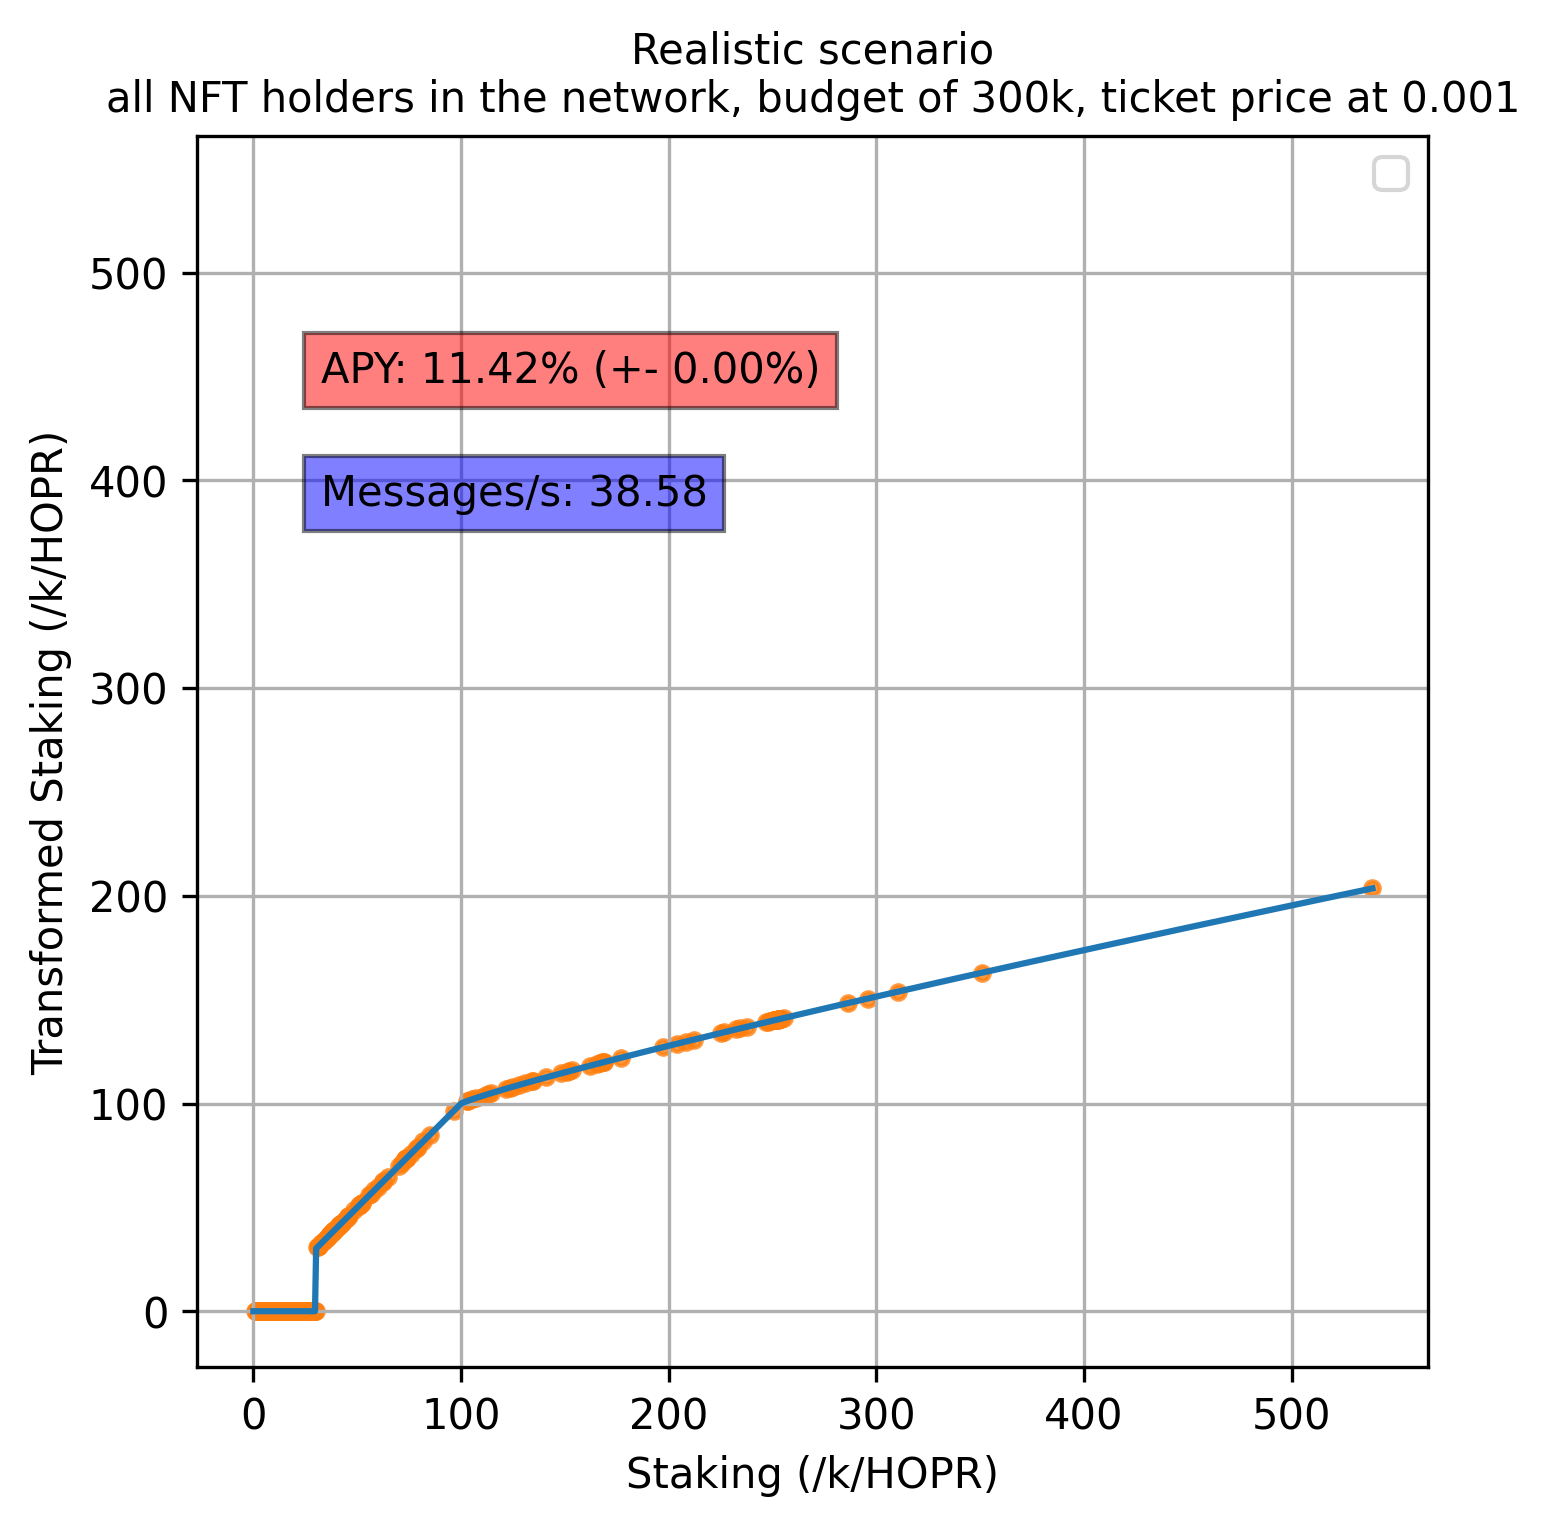

In [4]:
generate_simulation_graph(datas, [prefered], title=f"Realistic scenario\nall NFT holders in the network, budget of {prefered['budget']/1000:.0f}k, ticket price at 0.001")

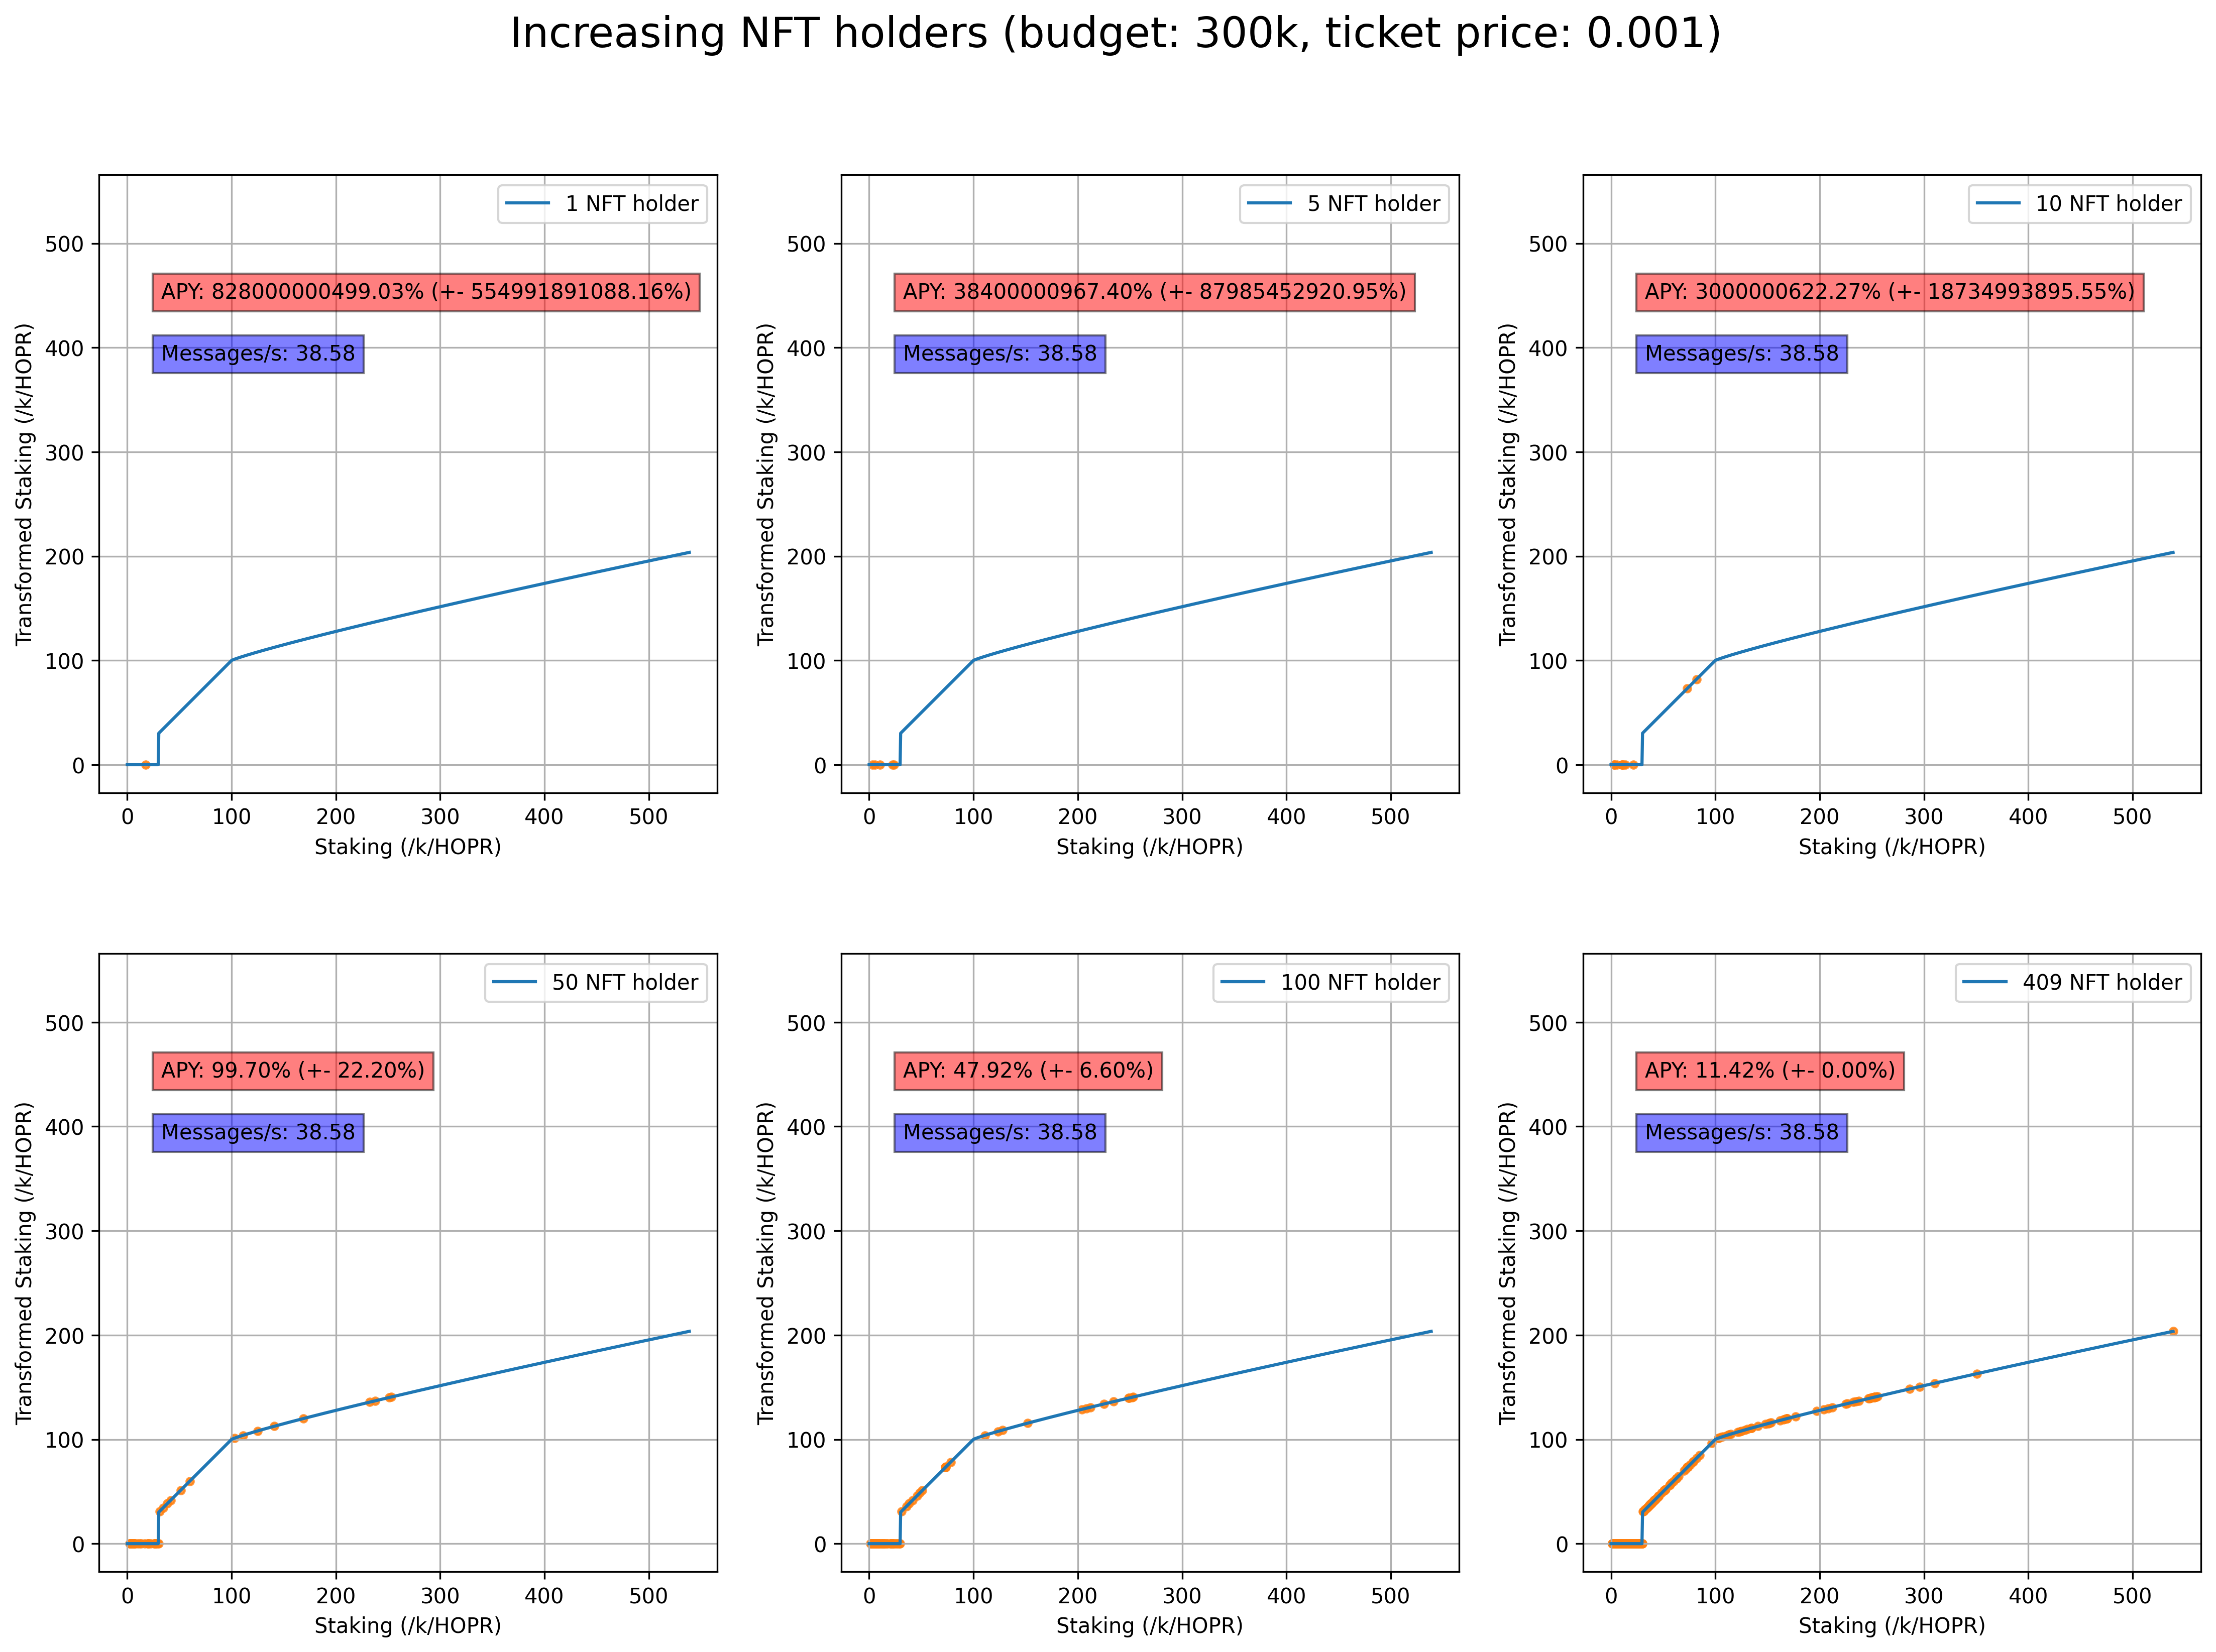

In [5]:
nft_holder_counts = [1, 5, 10, 50, 100, len(staking_info_nft_holders)]
options = [deepcopy(prefered) for _ in range(len(nft_holder_counts))]

for opt, count in zip(options, nft_holder_counts):
    opt["data_count"][0] = count
    opt["legend"] = f"{count} NFT holder"


generate_simulation_graph(datas, options, title=f"Increasing NFT holders (budget: {options[0]['budget']/1000:.0f}k, ticket price: {options[0]['ticket_options']['price']})")

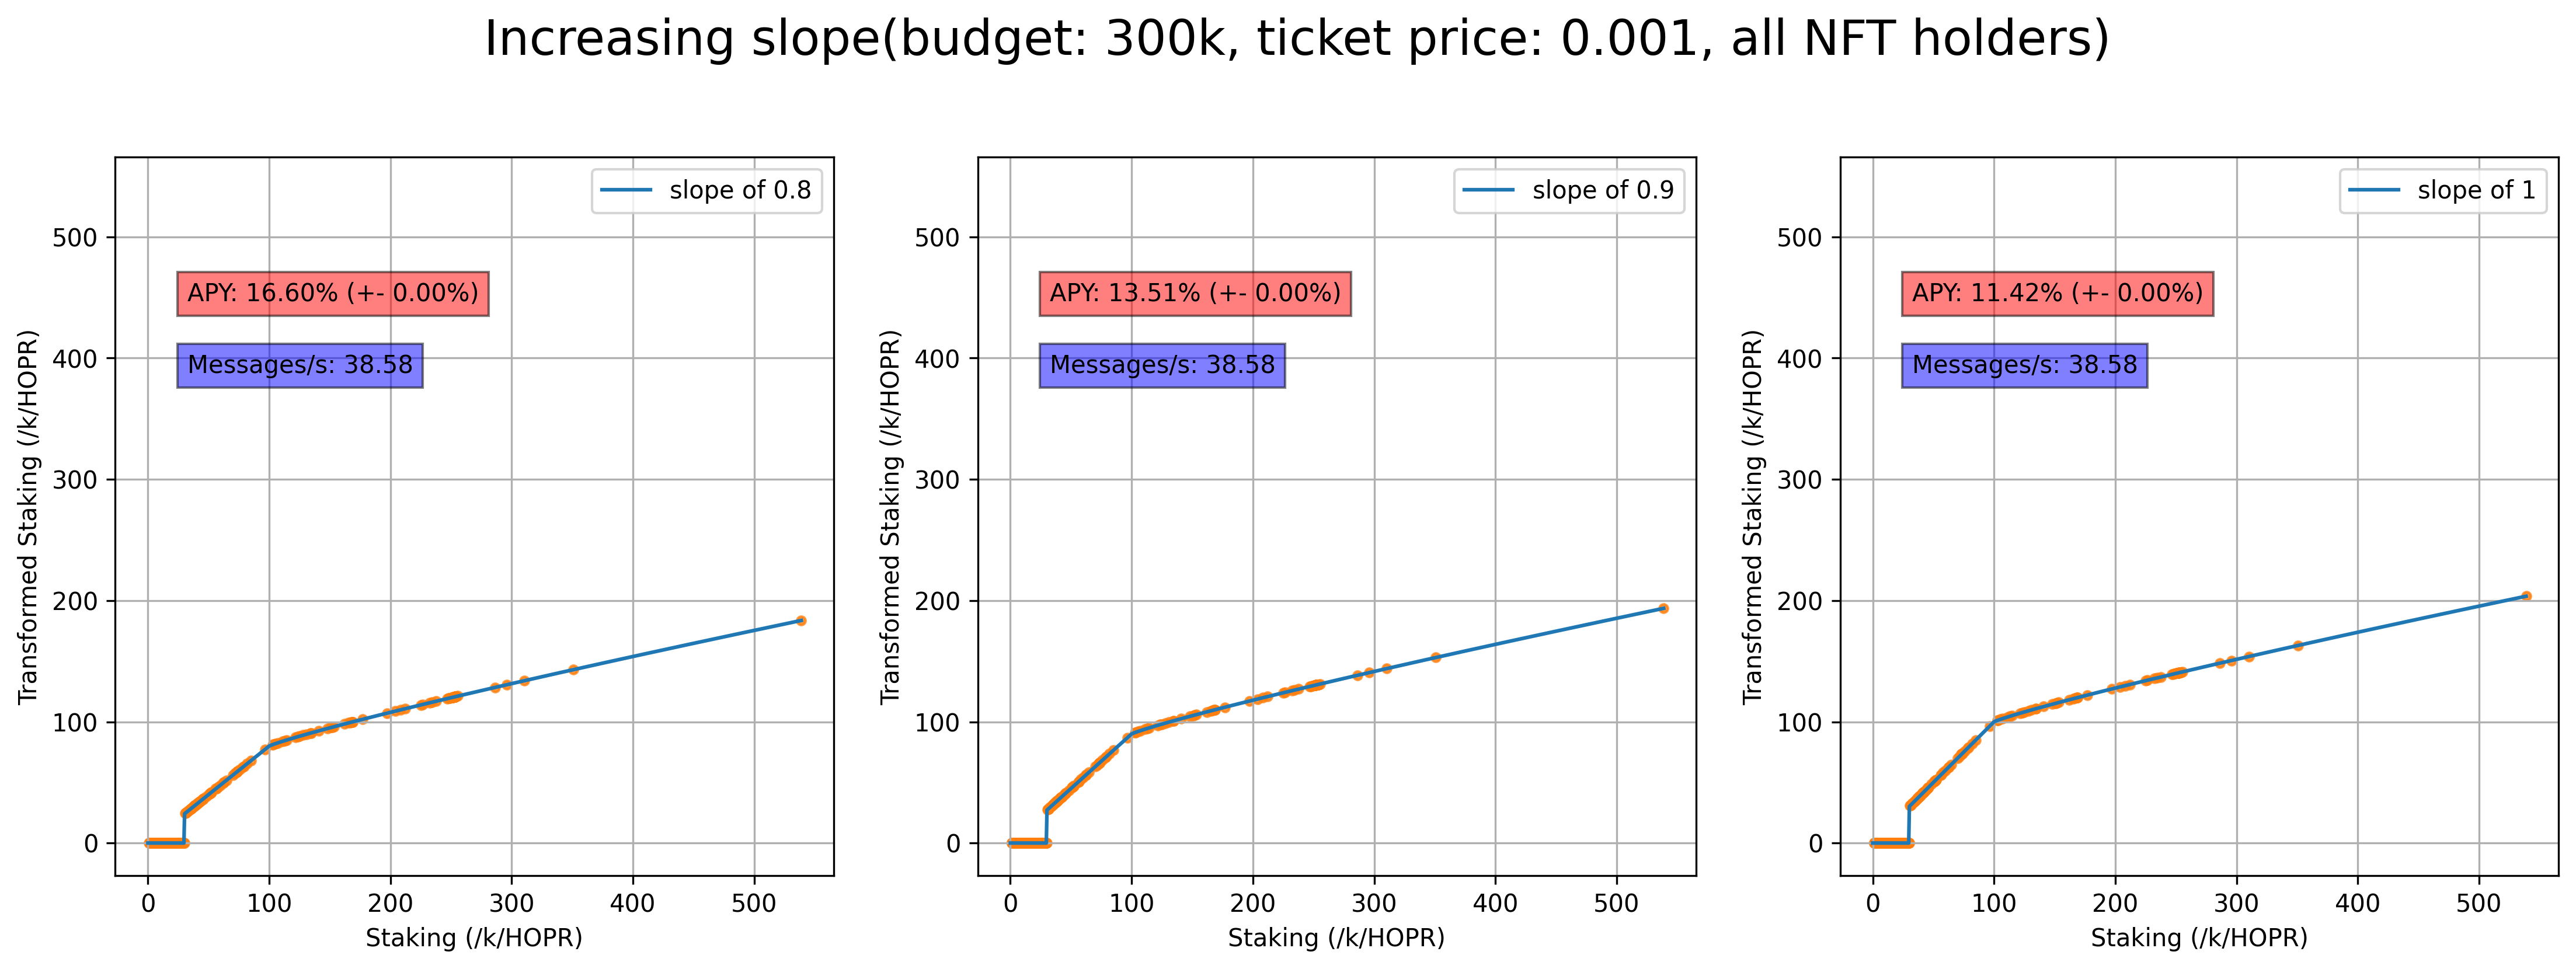

In [6]:
slopes = [0.8, 0.9, 1]
options = [deepcopy(prefered) for _ in range(len(slopes))]

for opt, slope in zip(options, slopes):
    opt["model_arguments"]["slope"] = slope
    opt["legend"] = f"slope of {slope}"

generate_simulation_graph(datas, options, 200, title=f"Increasing slope(budget: {options[0]['budget']/1000:.0f}k, ticket price: {options[0]['ticket_options']['price']}, all NFT holders)")

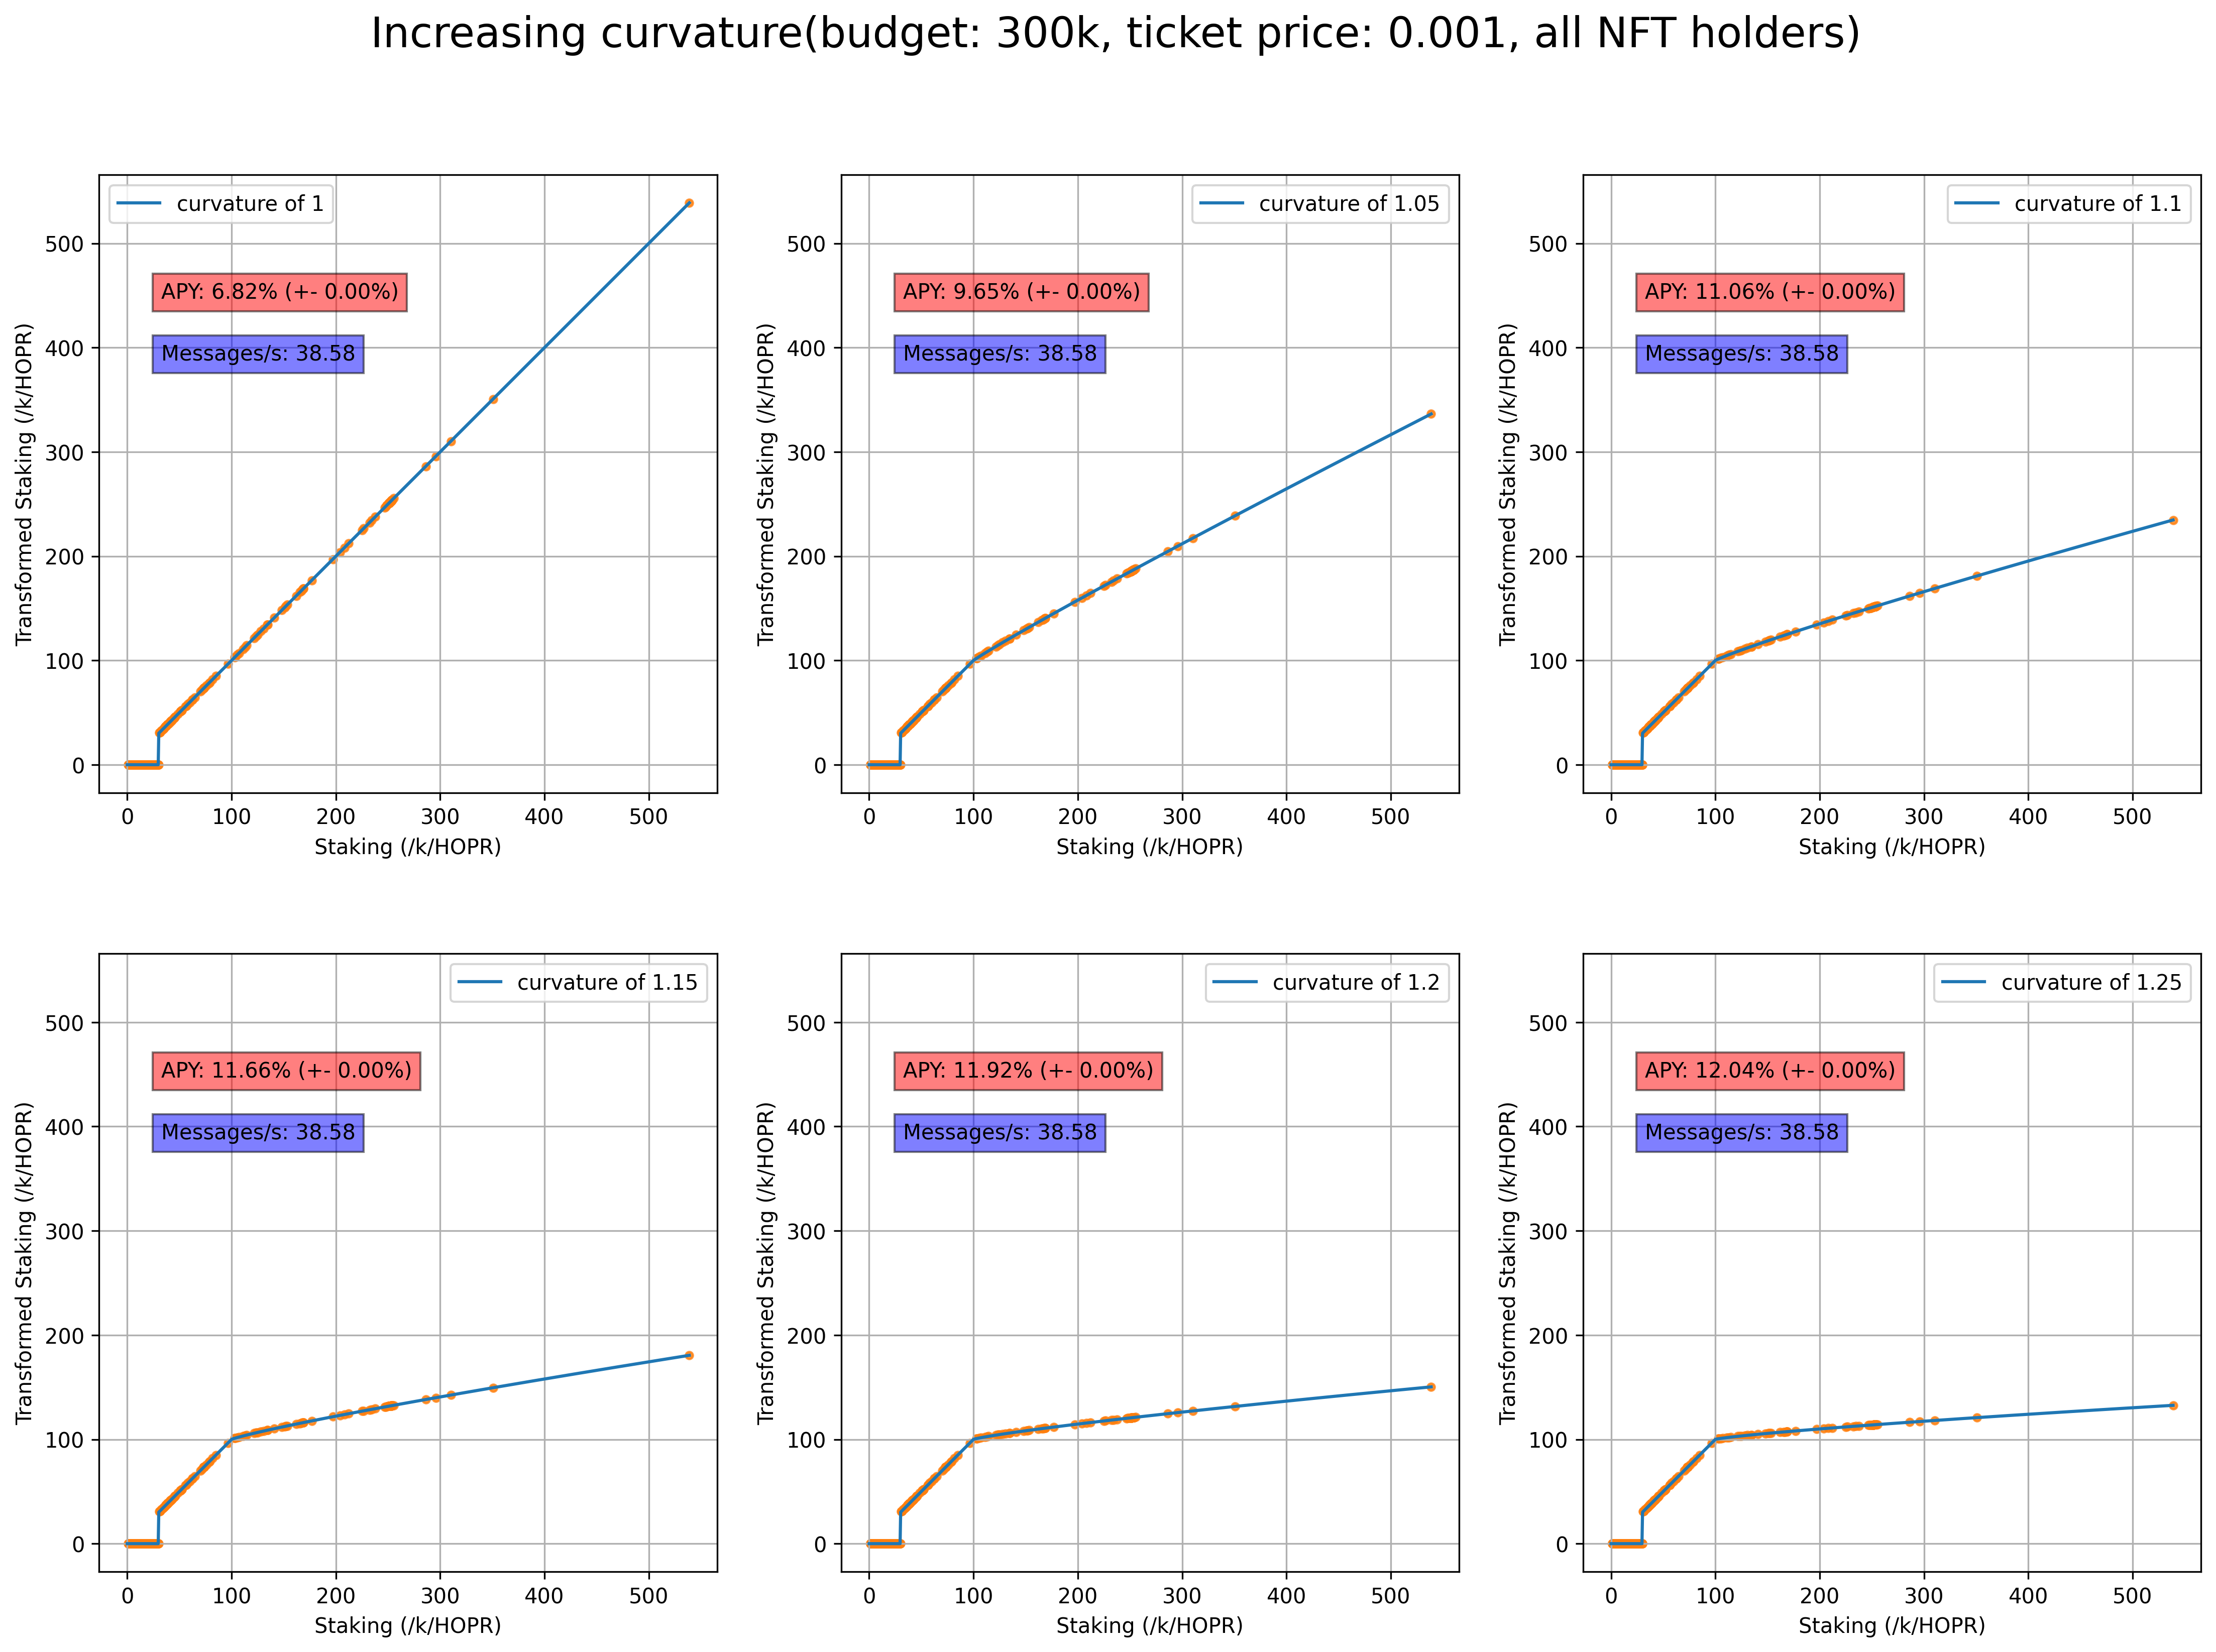

In [7]:
curvatures = [1, 1.05, 1.1, 1.15, 1.2, 1.25]
options = [deepcopy(prefered) for _ in range(len(curvatures))]

for opt, curvature in zip(options, curvatures):
    opt["model_arguments"]["curvature"] = curvature
    opt["legend"] = f"curvature of {curvature}"

generate_simulation_graph(datas, options, 200, title=f"Increasing curvature(budget: {options[0]['budget']/1000:.0f}k, ticket price: {options[0]['ticket_options']['price']}, all NFT holders)")

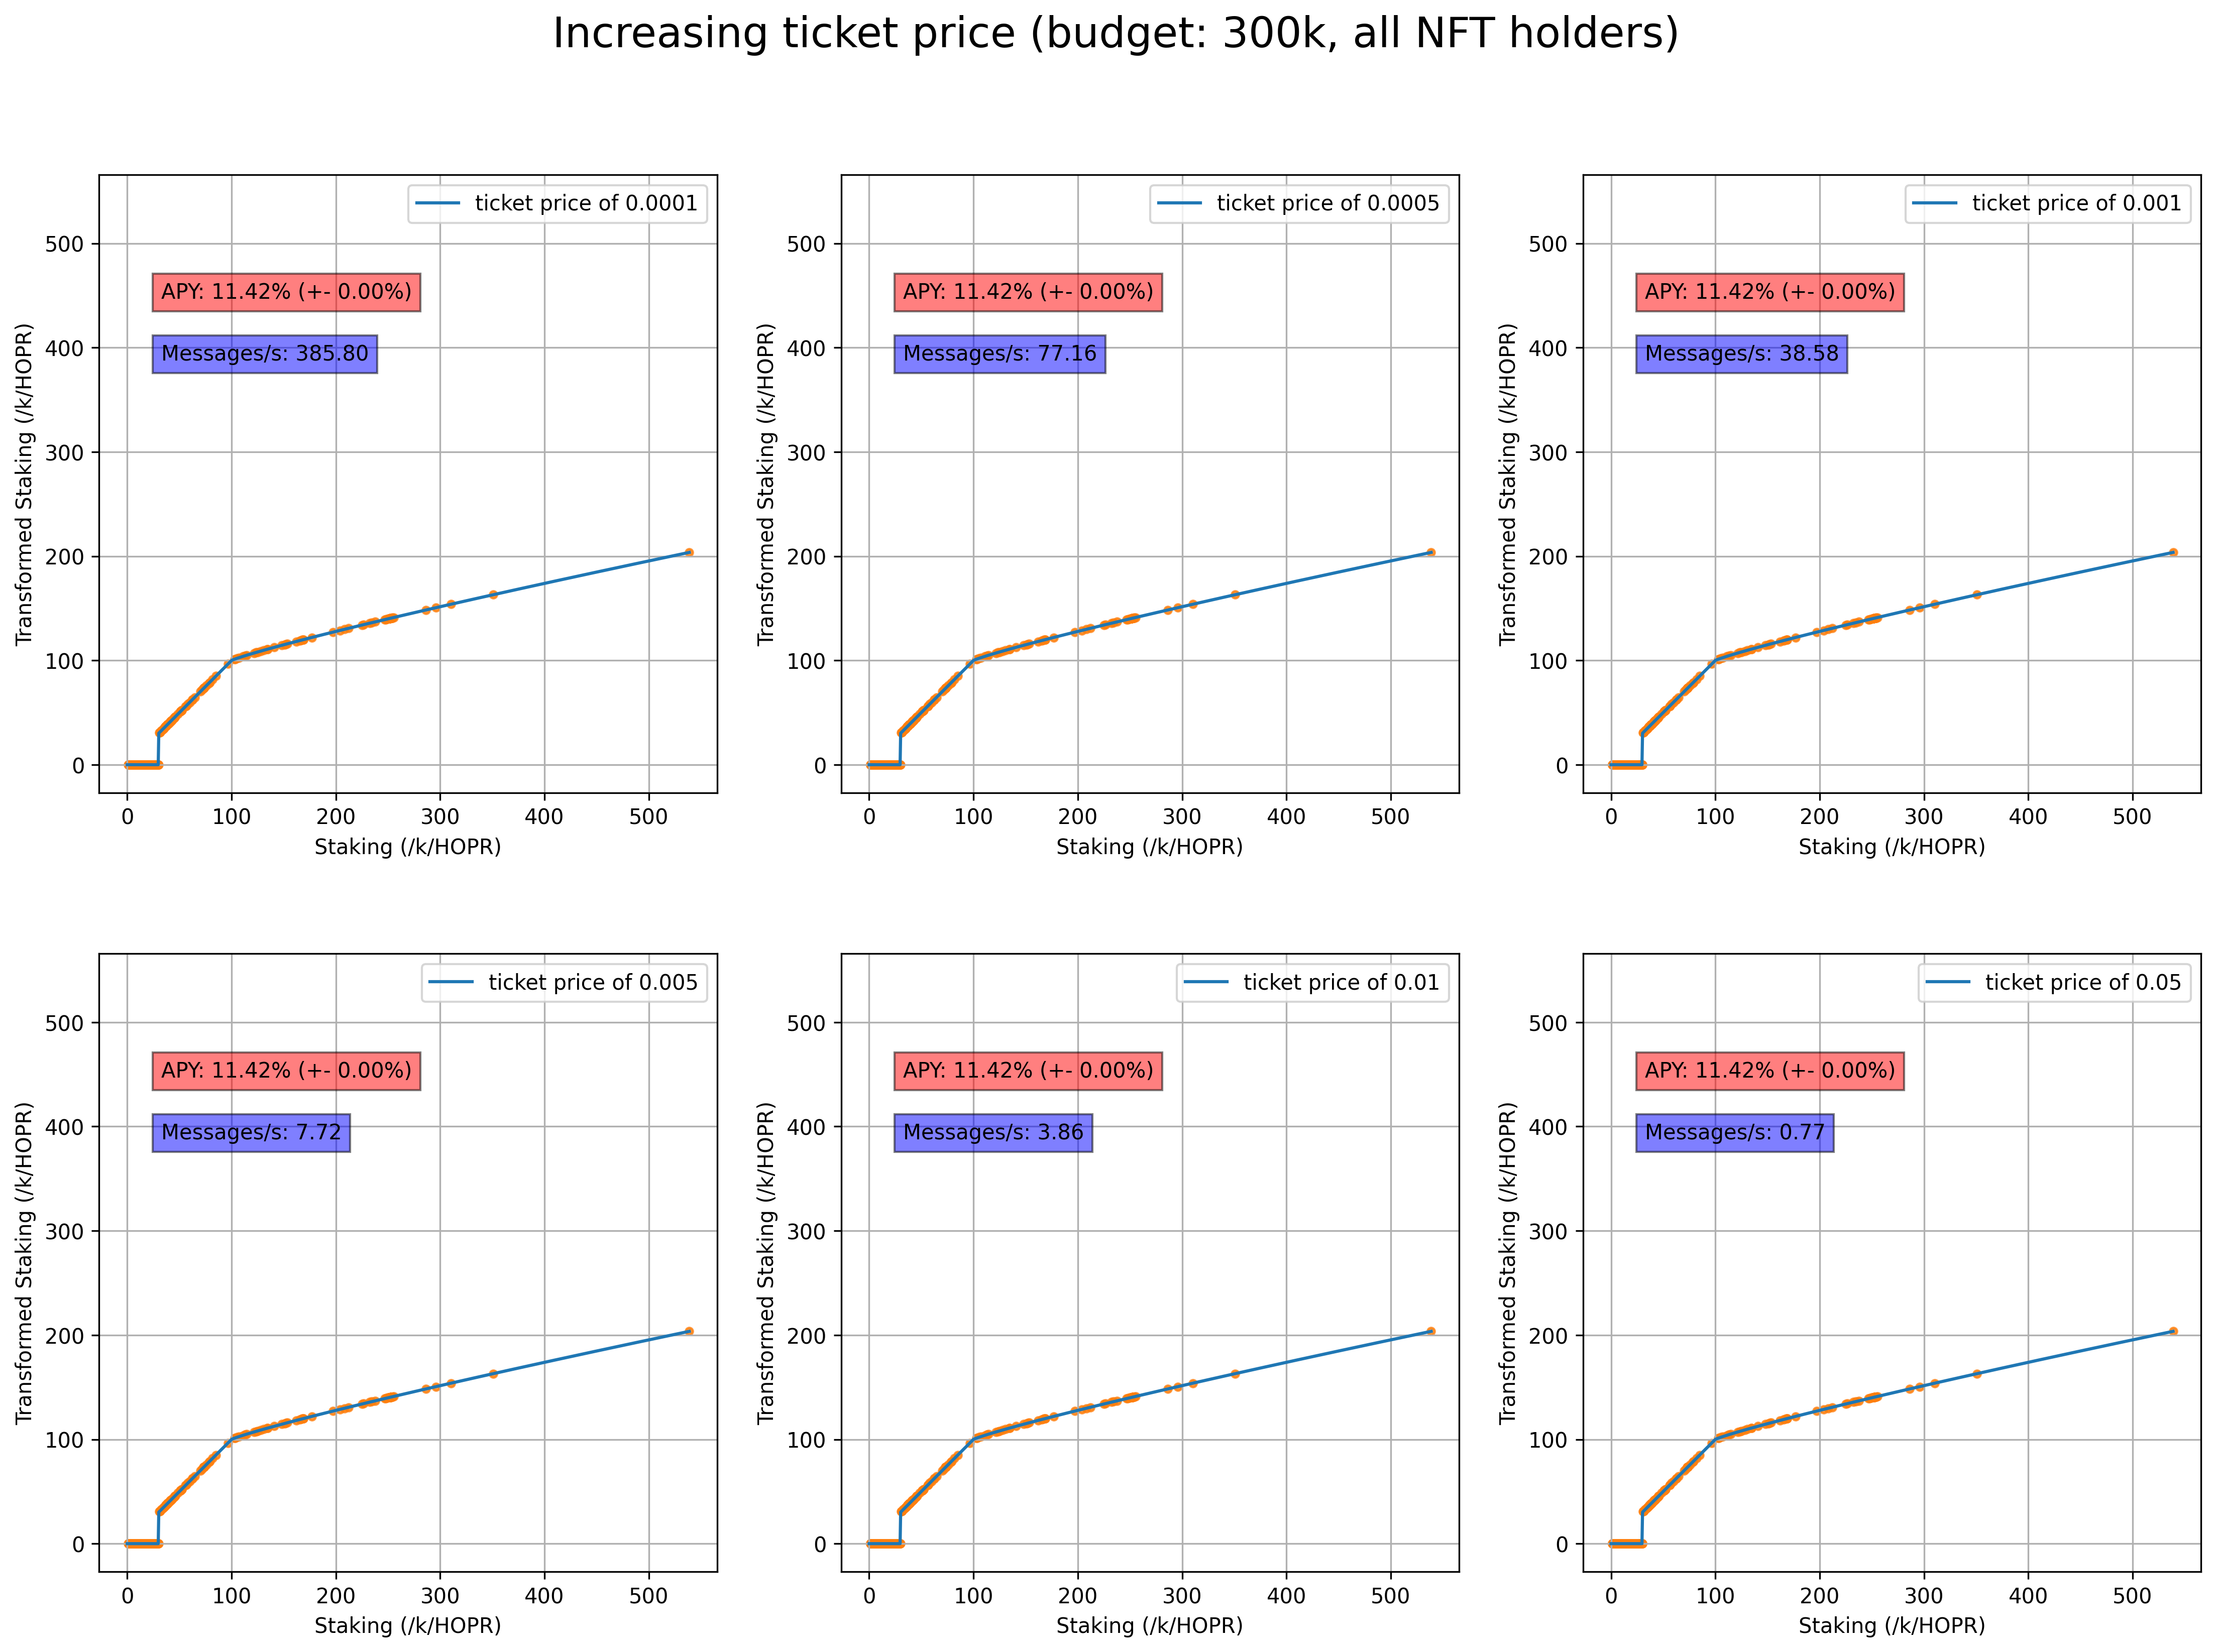

In [8]:
ticket_prices = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]
options = [deepcopy(prefered) for _ in range(len(ticket_prices))]

for opt, ticket_price in zip(options, ticket_prices):
    opt["ticket_options"]["price"] = ticket_price
    opt["legend"] = f"ticket price of {ticket_price}"

generate_simulation_graph(datas, options, title=f"Increasing ticket price (budget: {options[0]['budget']/1000:.0f}k, all NFT holders)")

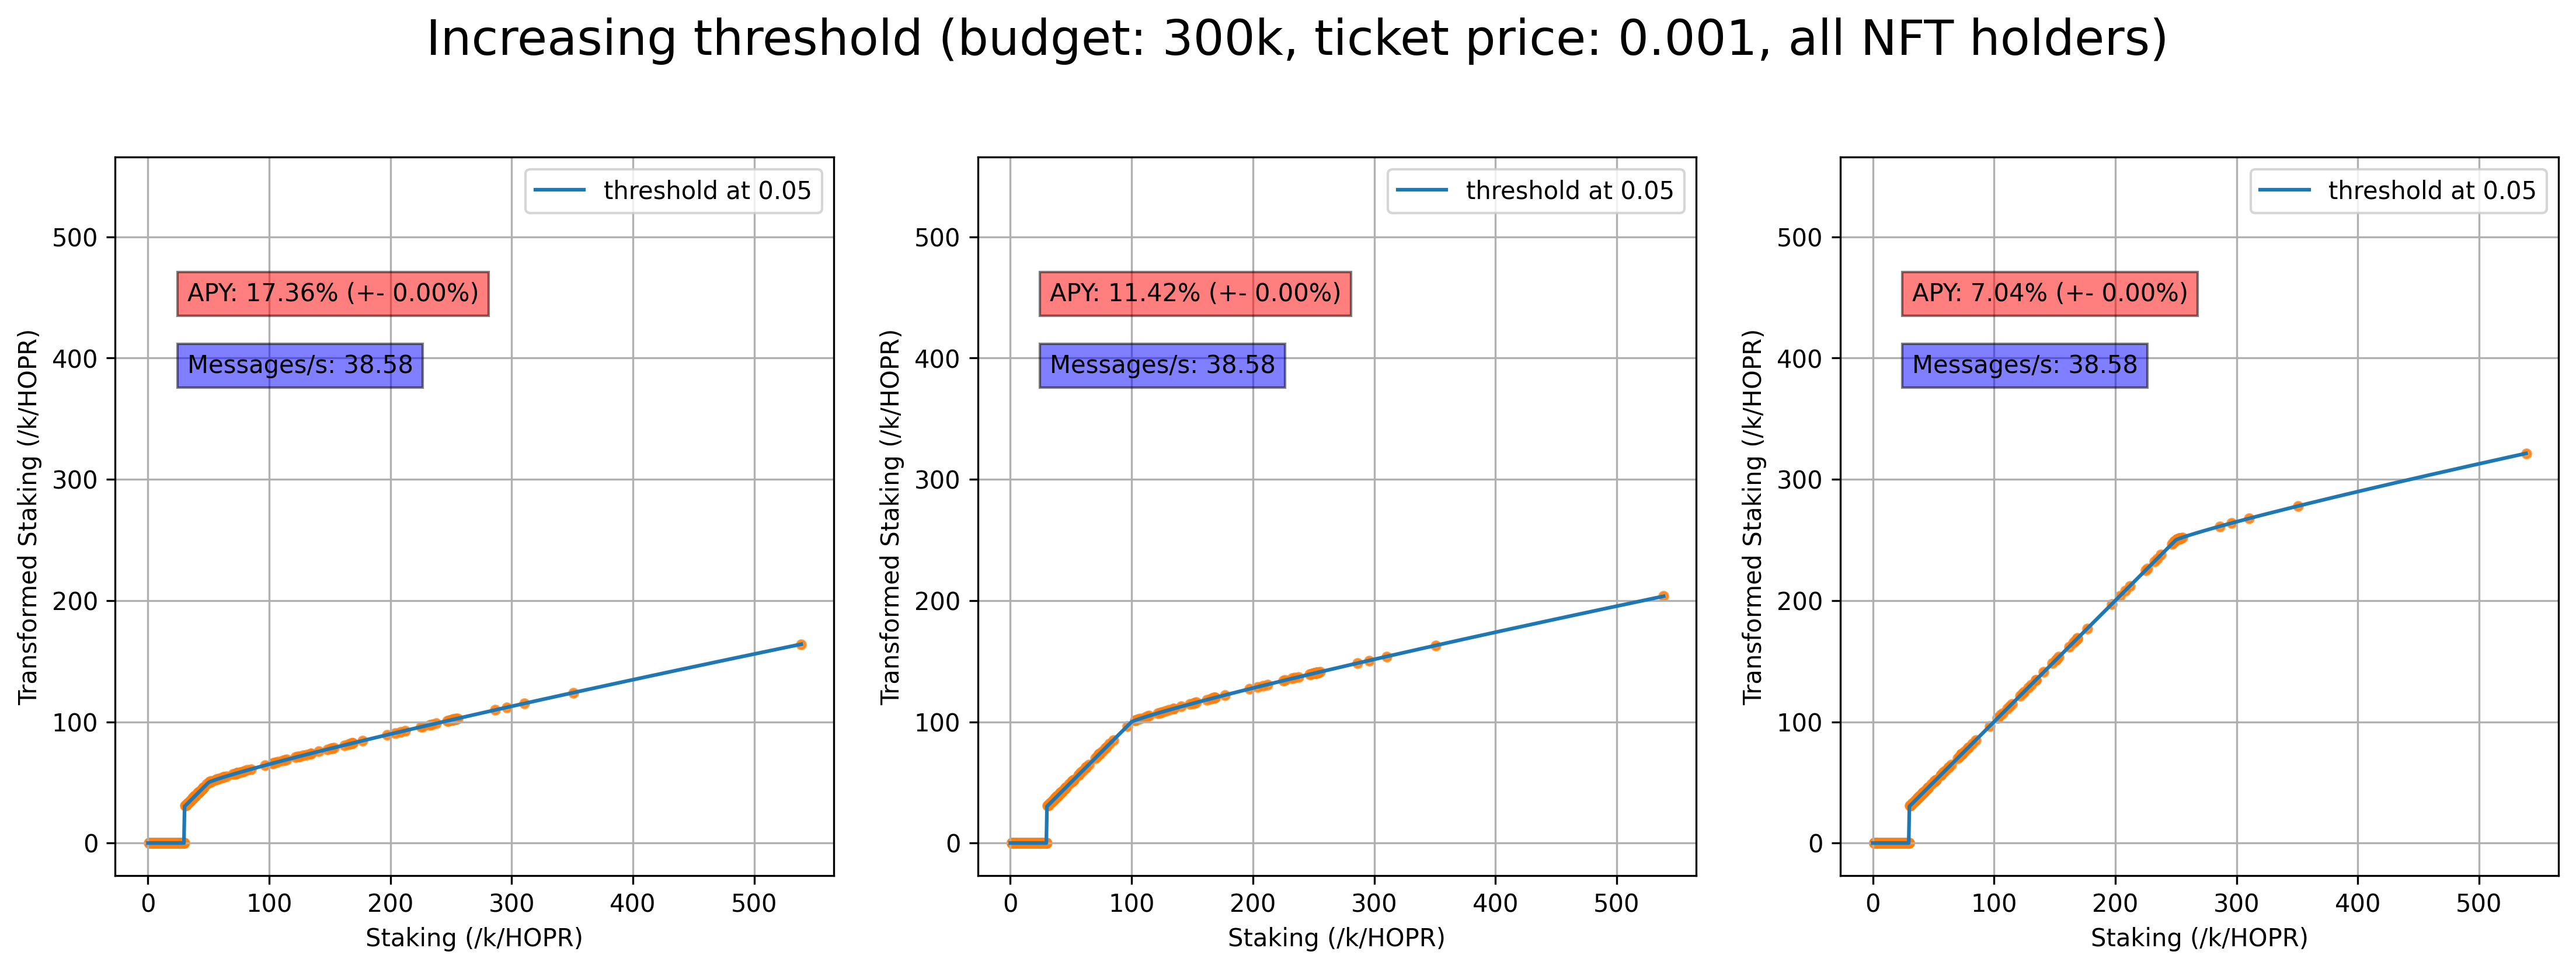

In [9]:
thresholds = [50e3, 100e3, 250e3]
options = [deepcopy(prefered) for _ in range(len(thresholds))]

for opt, threshold in zip(options, thresholds):
    opt["model_arguments"]["threshold"] = threshold
    opt["legend"] = f"threshold at {ticket_price}"


generate_simulation_graph(datas, options, title=f"Increasing threshold (budget: {options[0]['budget']/1000:.0f}k, ticket price: {options[0]['ticket_options']['price']}, all NFT holders)")

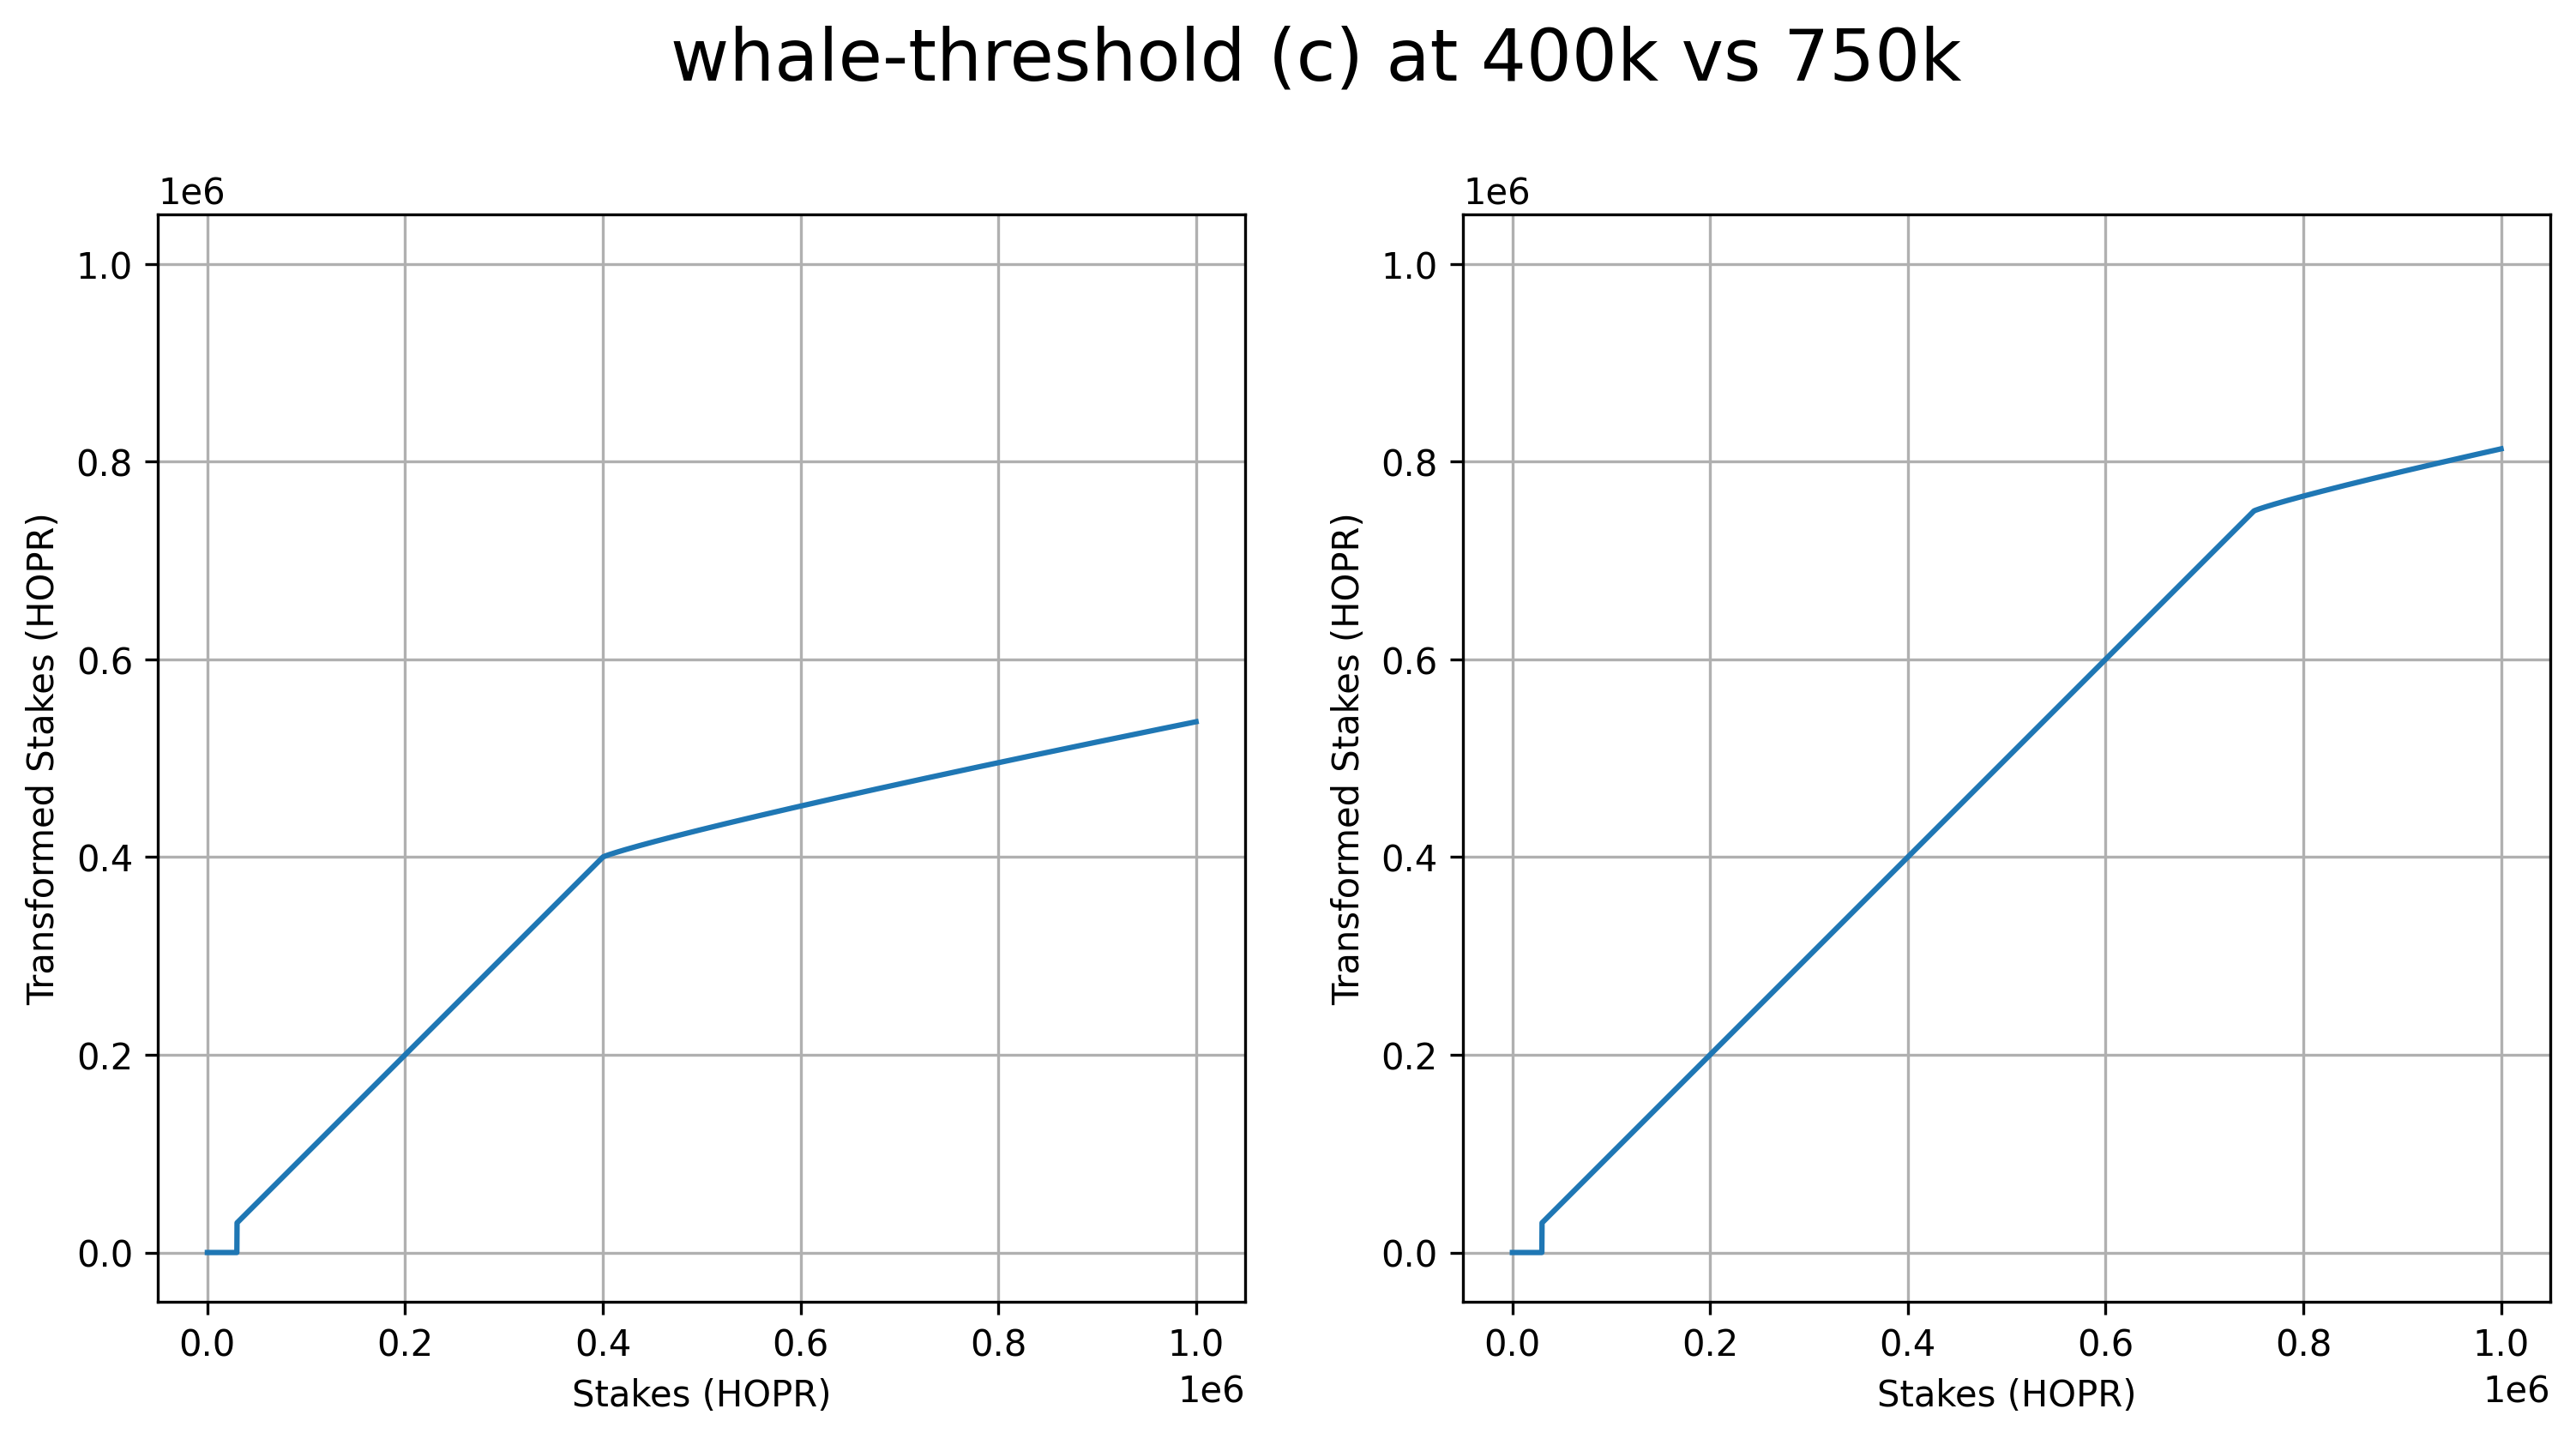

In [10]:
options = [{
    "model_arguments": {
        "slope": 1,
        "curvature":1.125,
        "threshold":400e3,
    }
},
{
    "model_arguments": {
        "slope": 1,
        "curvature":1.125,
        "threshold":750e3,
    }
}
]

generate_simulation_graph_simple(options, 5000, title="whale-threshold (c) at 400k vs 750k")

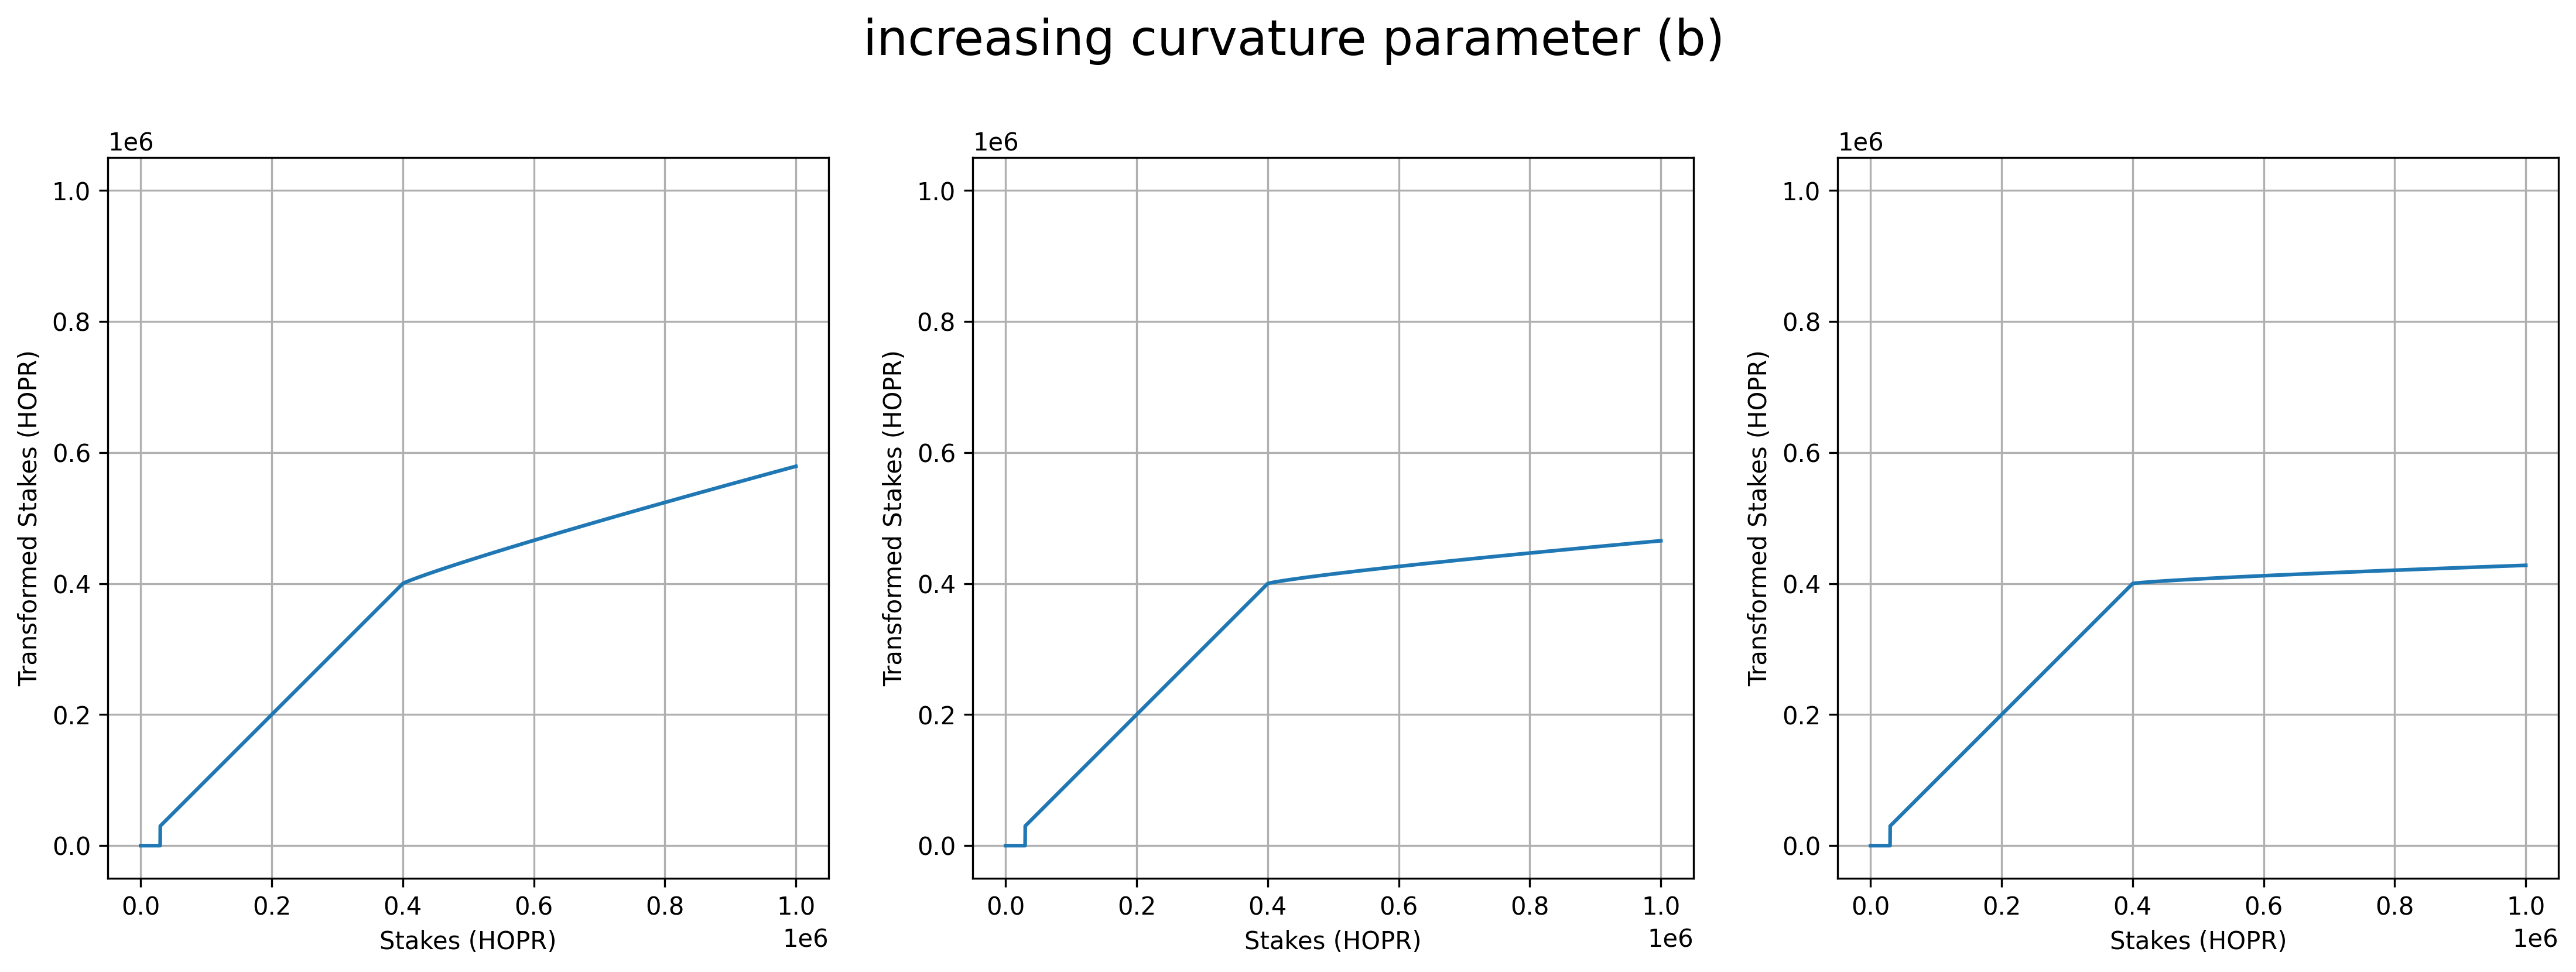

In [13]:
options = [{
    "model_arguments": {
        "slope": 1,
        "curvature":1.1,
        "threshold":400e3,
    }
},
{
    "model_arguments": {
        "slope": 1,
        "curvature":1.200,
        "threshold":400e3,
    }
},
{
    "model_arguments": {
        "slope": 1,
        "curvature":1.3,
        "threshold":400e3,
    }
}
]

generate_simulation_graph_simple(options, 5000, title="increasing curvature parameter (b)")

In [12]:
print(f"min stake: {min(staking_info_nft_holders):.2f} HOPR")
print(f"max stake: {max(staking_info_nft_holders):.2f} HOPR")
print(f"average stake: {np.mean(staking_info_nft_holders):.2f} HOPR")
print(f"median stake: {np.median(staking_info_nft_holders):.2f} HOPR")
print(f"total reward: {sum(list(raw_data[~condition]['rewards_till_now'])):.2f} HOPR")


min stake: 1000.51 HOPR
max stake: 538801.21 HOPR
average stake: 49534.33 HOPR
median stake: 11156.54 HOPR
total reward: 1020837.41 HOPR
